# Interactive exploration tool for assessment schemes in ICNIRP 2020 and RPS S-1
author: Dr Vitas Anderson (*Two Fields Consulting*)

date: 9/9/2021

To use this Jupyter notebook, run each code cell in succession by either pressing the triangular run button ► in the menu bar above or by pressing SHIFT-ENTER for successive code cells. You can play around with the code as much as you like - it won't affect the original notebook.

Under the **Interactive Assessment Explorer Tool** heading below you will find an interactive tool for visualising limit-normalised exposure assessments from two RF sources for the following assessment schemes:

+ **Lwbps**: whole body point spatial (the scheme which is currently used for EME calcuated assessments)
+ **Llocps**: local point spatial
+ **Lwbsa**: whole body spatial average (as now required for whole body exposure to E/H/S in ICNIRP 2020 and RPS S-1)
+ **Lwbpssa**: a point spatial representation of the whole body spatial average

The assessments are conducted on artificial RF limit-normalised power density exposure distributions using the following formula:

$\Large L_{wbps} = \frac{k_1}{\textrm{cosh}(k_2(z-z_{source}))}$

where:

+ $z$ is the height of the evaluation point
+ $z_{source}$ is the height of the RF source
+ $k_1$ is a parameter to vary the intensity of the source field
+ $k_2$ is a parameter to vary the vertical beam width of the source

## Import python modules

In [ ]:
%matplotlib widget
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from collections import namedtuple
from collections.abc import Iterable
pd.options.display.max_rows = 201
np.set_printoptions(precision=4)

## Object class for interactive Assessment Explorer tool

In [2]:
plt.close('all')
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

class Ass(widgets.HBox):
    '''This object class generates an interactive widget tool for calculating
       assessment distributions over a set z height range for:
       + point spatial limit normalised field values for whole body exposure (Lwbps)
       + point spatial limit normalised field values for local exposure (Llocps)
       + spatial average of the whole body Lps points (Lwbsa) over a vertical line
       + point spatial representation of the whole body spatial averages (Lwbpssa)
       
       FUNCTION INPUTS:       
          h = height of the spatial averaging window (m)
       nsap = number of spatial averaging points [3 or 5]
   nsap_num = maximum umber of valid nsap options to display in the nsap radio widget
       fMHz = exposure frequency in MHz
       zlow = lower bound of the z points (m)
      zhigh = upper bound of the z points (m)
         dz = distance increment between z points (m)
        k1s = list of k1 parameters that set the peak level of the Lps distribution, 
              e.g. 2 for a single source or [2,1] for two sources
        k2s = list of k2 parameters that set the vertical beamwidth of the Lps distribution
              e.g. 1 for a single source or [1,2] for two sources
        zs = list of heights (m) for the source(s), 
              e.g. 7 for a single source, or [10,13] for two sources
        plot_height = height of the plot in the widget tool (in)
         
       FUNCTION OUTPUTS:
         an interactive widget tool which can be displayed using: display(Ass_object)
      '''  
    
    def __init__(self, h=2, nsap=5, nsap_num=7, fMHz=400, 
                 zlow=0, zhigh=12, dz=0.1,
                 k1s=[1,2], k2s=[2,2], zs=[8, 4],
                 plot_height=8):
        super().__init__()
        
        # Create output widget for the plot
        output = widgets.Output()
        
        # Create self variables from init values
        self.h = h
        self.nsap = nsap
        self.nsap_num = nsap_num
        self.fMHz = fMHz
        self.zlow = zlow
        self.zhigh = zhigh
        self.dz = dz
        
        # Do input value checks
        self.k1s,self.k2s,self.zs = check_source_inputs(k1s,k2s,zs)
        self.nz, self.nh, self.nh2 = check_dz(dz,h,zlow,zhigh)
        
        # Calculate z distribution
        self.z = calc_z(self.zlow,self.zhigh,self.nz)
        
        # Calculate all initial assessment values
        self.nsap, self.valid_nsap, self.nh, self.nh2, self.hindices = \
          self.calc_variables(self.dz,self.h,self.zlow,self.zhigh,self.nsap,self.nsap_num)
        self.calc_ass()

        # Create plot
        with plt.ioff():
            with output:
                # self.fig, self.ax = plt.subplots(constrained_layout=True, figsize=(4, plot_height))
                self.fig, self.ax = plt.subplots(figsize=(4, plot_height))
                display(self.fig.canvas)
            
        self.lineLwbps, = self.ax.plot(self.Lwbps, self.z, alpha=0.4, label='wb point spatial')
        self.lineLlocps, = self.ax.plot(self.Llocps, self.z, alpha=0.4, label='local point spatial')
        self.lineLwbsa, = self.ax.plot(self.Lwbsa, self.z, alpha=0.4, label='wb spatial average')
        self.lineLwbpssa, = self.ax.plot(self.Lwbpssa, self.z, alpha=0.4, label='wb point spatial spatial avg')
        self.lineLexceed, = self.ax.plot(self.Lexceed, self.z, c='r',lw=2,alpha=1,
                                         label='Lwbpssa > Lwbps')
        
        self.fig.canvas.toolbar_position = 'bottom'
        self.fig.canvas.header_visible = False
        self.ax.set_xlabel('Limit normalised field value')
        self.ax.set_ylabel('z (m)')
        self.ax.grid(True, ls='--', alpha=0.5)
        self.ax.legend()
        zmin, zmax = int(self.zlow), int(self.zhigh)
        self.ax.set_yticks(range(zmin,zmax+1))
        self.ax.set_ylim(zmin,zmax)
        self.set_title()

        # Plot annotation 
        # Use this if needed for debugging. Update text with self.set_text
        self.text = self.ax.text(0.3,12,'')

        # define widgets
        zsA_slider = widgets.FloatSlider(
            value=self.zs[0],
            min=self.zlow, 
            max=self.zhigh, 
            step=self.dz, 
            description='Source A',
            orientation='vertical',
            layout=widgets.Layout(height=f'{plot_height}in'),
        )
        zsB_slider = widgets.FloatSlider(
            value=self.zs[1],
            min=self.zlow, 
            max=self.zhigh, 
            step=self.dz, 
            description='Source B',
            orientation='vertical',
            layout=widgets.Layout(height=f'{plot_height}in'),
        )
        self.nsap_radio = widgets.RadioButtons(
            options=self.valid_nsap,
            value=self.nsap,
            description='nsap:',
            orientation='horizontal',
            disabled=False
        )
        k1A_float = widgets.FloatText(
            value=self.k1s[0],
            step=0.1,
            description='k1',
            continuous_update=False,
            disabled=False,
        )               
        k2A_float = widgets.FloatText(
            value=self.k2s[0],
            step=0.1,
            description='k2',
            continuous_update=False,
            disabled=False,
        )               
        k1B_float = widgets.FloatText(
            value=self.k1s[1],
            step=0.1,
            description='k1',
            continuous_update=False,
            disabled=False,
        )               
        k2B_float = widgets.FloatText(
            value=self.k2s[1],
            step=0.1,
            description='k2',
            continuous_update=False,
            disabled=False,
        )               
        h_slider = widgets.FloatSlider(
            value=self.h,
            min=0.2, 
            max=2, 
            step=0.1, 
            description='h (m)',
            layout=widgets.Layout(width='4in'),
            readout_format='.1f',
            continuous_update=False,
        )
        
        # define left controls
        height_sliders = widgets.HBox([
            zsA_slider, 
            zsB_slider, 
        ])
        
        left_controls = widgets.VBox([
            widgets.HTML("<u>Source heights</u>"),
            height_sliders,            
        ])
        
        left_controls.layout = make_box_layout()
        
        # define right controls
        right_controls = widgets.VBox([
            widgets.HTML("<u>Spatial averaging parameters</u>"),
            h_slider,
            self.nsap_radio,
            widgets.HTML("<u>Source A</u>"),
            k1A_float,
            k2A_float,
            widgets.HTML("<u>Source B</u>"),
            k1B_float, 
            k2B_float,
        ])
        
        right_controls.layout = make_box_layout()
        
        # define output
        out_box = widgets.Box([output])
        out_box.layout = make_box_layout()

        # observe stuff
        zsA_slider.observe(self.zsA_change, 'value')
        zsB_slider.observe(self.zsB_change, 'value')       
        h_slider.observe(self.h_change, 'value')       
        k1A_float.observe(self.k1A_change, 'value')       
        k2A_float.observe(self.k2A_change, 'value')       
        k1B_float.observe(self.k1B_change, 'value')       
        k2B_float.observe(self.k2B_change, 'value')
        self.nsap_radio.observe(self.nsap_change, 'value')

        # Define the children in the Ass object Hbox
        self.children = [left_controls, out_box, right_controls]
    
    def set_text(self):
        txt = f'valid_nsap = {self.valid_nsap}\nnsap = {self.nsap}\nh = {self.h}\nnh = {self.nh}'
        self.text.set_text(txt)
    
    def nearest_nsap(self, nsap, nh, nsap_num=None):
        '''Get the nearest valid value of nsap to the current nsap'''
        valid_nsap = calc_valid_nsap(nh, n=nsap_num)
        abs_diff = np.abs(np.array(valid_nsap) - nsap)
        index = abs_diff.argmin()
        nsap = valid_nsap[index]
        return nsap, valid_nsap

    def calc_variables_old(self):
        '''Calculate all preliminary assessment variables'''
        self.nz,self.nh,self.nh2 = check_dz(self.dz,self.h,self.zlow,self.zhigh)
        self.nsap,self.valid_nsap = self.nearest_nsap(self.nsap,self.nh,self.nsap_num)
        self.hindices = calc_hindices(self.nh, self.nh2, self.nsap)
        
    def calc_variables(self, dz, h, zlow, zhigh, nsap, nsap_num):
        '''Calculate preliminary assessment variables'''
        nz, nh, nh2 = check_dz(dz, h, zlow, zhigh)
        nsap, valid_nsap = self.nearest_nsap(nsap, nh, nsap_num)
        hindices = calc_hindices(nh, nh2, nsap)
        return nsap, valid_nsap, nh, nh2, hindices 
        
    def calc_ass(self):
        '''Calculate all assessment distributions'''
        self.Lwbps = calc_Lwbps(self.k1s,self.k2s,self.zs,self.z,self.nz)
        self.Llocps = calc_Llocps(self.Lwbps, self.fMHz)
        self.Lwbsa = calc_Lwbsa(self.Lwbps, self.nz, self.nh2, self.hindices)
        self.Lwbpssa = calc_Lwbpssa(self.Lwbsa, self.nz, self.nh, self.nh2)
        
        # Identify Lwbpssa points where Lwbpssa is less restrictive than Lwbps
        self.Lexceed = self.Lwbpssa.copy()
        mask = self.Lwbpssa >= self.Lwbps
        self.Lexceed[~mask] = np.nan        
           
    def set_title(self):
        title = f'{self.nsap} points over {self.h}m\n' + \
                '$k_1$' + f'={",".join(map(str,self.k1s))}, ' + \
                '$k_2$' + f'={",".join(map(str,self.k2s))}, f={self.fMHz} MHz'
        self.fig.suptitle(title)

    def line_update(self, Lwbps, Llocps, Lwbsa, Lwbpssa, Lexceed):
        """update assessment lines in plot"""
        self.lineLwbps.set_xdata(Lwbps)
        self.lineLlocps.set_xdata(Llocps)
        self.lineLwbsa.set_xdata(Lwbsa)
        self.lineLwbpssa.set_xdata(Lwbpssa)
        self.lineLexceed.set_xdata(Lexceed)
        self.fig.canvas.draw()

    def h_change(self, change):
        self.h = change.new
        self.nsap, self.valid_nsap, self.nh, self.nh2, self.hindices = \
          self.calc_variables(self.dz,self.h,self.zlow,self.zhigh,self.nsap,self.nsap_num)
        self.calc_ass()
        self.line_update(self.Lwbps, self.Llocps, self.Lwbsa, self.Lwbpssa, self.Lexceed)
        self.set_title()
        
        # Update nsap_radio widget. Note that we need to 'unobserve' the nsap_radio widget
        # while updating it since it will otherwise trigger a callback when changing it
        self.nsap_radio.unobserve(self.nsap_change, 'value')
        self.nsap_radio.options = self.valid_nsap
        self.nsap_radio.value = self.nsap
        self.nsap_radio.observe(self.nsap_change, 'value')
        
    def nsap_change(self, change):
        self.nsap = change.new
        self.nsap, self.valid_nsap, self.nh, self.nh2, self.hindices = \
          self.calc_variables(self.dz,self.h,self.zlow,self.zhigh,self.nsap,self.nsap_num)
        self.calc_ass()
        self.line_update(self.Lwbps, self.Llocps, self.Lwbsa, self.Lwbpssa, self.Lexceed)
        self.set_title()
        
    def zsA_change(self, change):
        self.zs[0] = change.new
        self.calc_ass()
        self.line_update(self.Lwbps, self.Llocps, self.Lwbsa, self.Lwbpssa, self.Lexceed)
        
    def zsB_change(self, change):
        self.zs[1] = change.new
        self.calc_ass()
        self.line_update(self.Lwbps, self.Llocps, self.Lwbsa, self.Lwbpssa, self.Lexceed)
        
    def k1A_change(self, change):
        self.k1s[0] = change.new
        self.calc_ass()
        self.line_update(self.Lwbps, self.Llocps, self.Lwbsa, self.Lwbpssa, self.Lexceed)   

    def k2A_change(self, change):
        self.k2s[0] = change.new
        self.calc_ass()
        self.line_update(self.Lwbps, self.Llocps, self.Lwbsa, self.Lwbpssa, self.Lexceed)   

    def k1B_change(self, change):
        self.k1s[1] = change.new
        self.calc_ass()
        self.line_update(self.Lwbps, self.Llocps, self.Lwbsa, self.Lwbpssa, self.Lexceed)   

    def k2B_change(self, change):
        self.k2s[1] = change.new
        self.calc_ass()
        self.line_update(self.Lwbps, self.Llocps, self.Lwbsa, self.Lwbpssa, self.Lexceed)   

## Functions

In [3]:
def make_list(obj):
    '''make sure obj is a list'''
    if isinstance(obj, Iterable):
        return list(obj)
    else:
        return [obj]    

def check_source_inputs(*sources, n=None):
    '''Make sure that all source inputs are lists which are of the same length
       and are of length n if n is specified'''
    sources = [make_list(source) for source in sources]
    len_sources = [len(source) for source in sources]
    errmsg = f'All source inputs {sources} must have the same number of elements'
    assert len(set(len_sources)) == 1, errmsg
    if n != None:
        errmsg = f'All k1s, k2s, zs source inputs {sources} must each have {n} elements'
        assert len_sources[0] == n, errmsg
    
    return sources

def check_dz(dz,h,zlow,zhigh):
    '''Check that dz is a valid input'''
    # check that the z range is divisible by dz
    zrange = zhigh - zlow
    nz = int(zrange/dz)   # number of dz intervals in z range
    assert nz == zrange/dz, f"z range ({zrange}) must be divisible by dz ({dz})"
    
    # check that spatial average window length is divisible by dz
    nh = int(h/dz)    # number of dz intervals within spatial averaging window    
    nh2 = int(nh/2)   # number of dz intervals between the centre and the end of the spatial averaging window
    assert nh == h/dz, f"h ({h}) must be divisible by dz ({dz})"  

    return nz, nh, nh2
    
def calc_z(zlow, zhigh, nz):
    '''Calculate the z distribution'''
    z = np.linspace(zlow, zhigh, nz+1)
    return z

def calc_Lwbps(k1s,k2s,zs,z,nz):
    '''Calculate the whole body point spatial distribution for limit normalised exposure (Lwbps)'''
    Lwbps = np.zeros(nz+1)                  # initialise Lwbps array with zeros
    for k1i, k2i, zi in zip(k1s, k2s, zs):  # loop through each source
        Lwbps += k1i / np.cosh(k2i*(z-zi))    # add limit normalized field level for each source
    return Lwbps

def calc_Llocps(Lwbps, fMHz):
    '''Calculate the local point spatial distribution for limit normalised exposure (Llocps)'''
    # Calculate the local limit multiplier factor
    if fMHz <= 400:
        m = 5
    elif fMHz < 2000:
        m = 11.47459891 * fMHz**-0.138646884
    else:
        m = 4
        
    # Calculate and return Llocps
    return Lwbps / m

def calc_valid_nsap(nh, n=None):
    '''Return list of no more than n valid numbers of spatial averaging points
       for any value of nh, the number of dz intervals in h
       If n = None, then show all valid numbers of spatial averaging points'''
    valid_nsap = [i+1 for i in range(1, nh+1) if (nh % i == 0)]
    if (n != None) and (len(valid_nsap) > n):
        valid_nsap = valid_nsap[:n]
    return valid_nsap

def calc_hindices(nh, nh2, nsap):
    '''Determine the array indices of the spatial averaging points
       relative to the assessment point'''
    dh = int(nh / (nsap-1))  # number of indices between spatial averaging points
    hindices = [-nh2 + i*dh for i in range(nsap)]
    hindices = np.array(hindices, dtype=int)  # convert list to numpy integer array
    return hindices

def calc_Lwbsa(Lwbps, nz, nh2, hindices):
    '''Calculate the whole body spatial average distribution (Lwbsa)'''   
    # initialise Lwbsa array with NaN's (Not a Number)
    Lwbsa = np.repeat(np.nan, nz+1)
    
    # calculate the mean value of Lwbps at the spatial averaging points
    for iz in range(nh2, nz-nh2+1):
        Lwbsa[iz] = Lwbps[hindices + iz].mean()
        
    return Lwbsa

#### Funtion for calculating Lwbpssa (whole body point spatial spatial average)
The **assessment explorer** uses this function to calculate `Lwbpssa`, so edit it to test out different ways of calculating it. 

In [4]:
def calc_Lwbpssa(Lwbsa, nz, nh, nh2):
    '''Calculate the point spatial representation of the wb spatial 
       average (Lwbpssa)
    INPUTS:
       Lwbsa = spatial average of the whole body limit normalised point 
               spatial field over a vertical line
       nz = number of dz intervals in the z range
       nh = number of dz intervals in the h averaging window
       nh2 = number of dz intervals in half of the h averaging window
    OUTPUTS:
       Lwbpssa = point spatial respresentation of the spatially 
                 averaged field (Lwbsa)
       '''
    # import scipy module to locate peak levels    
    from scipy.signal import find_peaks
    
    # initialise Lwbpssa array with NaN's (Not a Number)
    Lwbpssa = np.repeat(np.nan, nz+1)
    
    # first pass: assign Lwbpssa values based on minimum value of points that
    # are half an averaging window above or below the assessment point
    for iz in range(nh, nz-nh+1):
        Lwbpssa[iz] = Lwbsa[[iz-nh2, iz+nh2]].min() 
    
    # second pass: assign Lwbsa value at the point(s) where Lwbsa peaks,
    # i.e. where spatial averaging window exposure changes between head and feet
    ipeaks, _ = find_peaks(Lwbsa)  # get indices of local peaks of Lwbsa values    
    for iz in ipeaks:
        Lwbpssa[iz] = Lwbsa[iz]
        
    # third pass: assign minimum Lwbsa value for the length of the spatial averaging window
    # where Lwbsa is a minimum
    itroughs, _ = find_peaks(1/Lwbsa)  # get indices of local minimums of Lwbsa values
    for iz in itroughs:
        Lwbpssa[(iz-nh2):(iz+nh2)] = Lwbsa[iz]
        
    return Lwbpssa  

## Run the interactive assessment explorer tool
Use this tool to explore the effect of spatial averaging schemes on different exposure scenarios generated by two hypothetical RF sources over a vetical line of points in the z direction.

#### Formula for generating limit-normalised S field level of each source

$\Large L_{wbps} = \frac{k_1}{\textrm{cosh}(k_2(z-z_{source}))}$

where:

+ $z$ is the height of the evaluation point
+ $z_{source}$ is the height of the RF source
+ $k_1$ is a parameter to vary the level of the source field
+ $k_2$ is a parameter to vary the vertical beam width of the source

#### Create an instance of the assessment explorer
Alter z increment (`dz`), height of z points (`zhigh`), plot height (`plot_height`) and exposure frequency (`fMHz`) in the `Ass` arguments in the code cell below.

Use the widgets in the left panel to alter the heights of the two sources, A & B.

Use the widgets in the right panel to alter the spatial averaging parameters:

+ **h**: height of the spatial averaging window
+ **nsap**: number of sptial averaging points equally distributed across the height of the spatial averaging window. Note that radio button options for **nsap** are automatically updated for valid numbers depending on **h** and **dz**.

The $k_1$ and $k_2$ parameters of source A & B can also be adjusted in the left panel.

The heavy red line in the plots indicates where the traditional approach of using `Lwbps` is actually less conservative than using `Lwbpssa`.

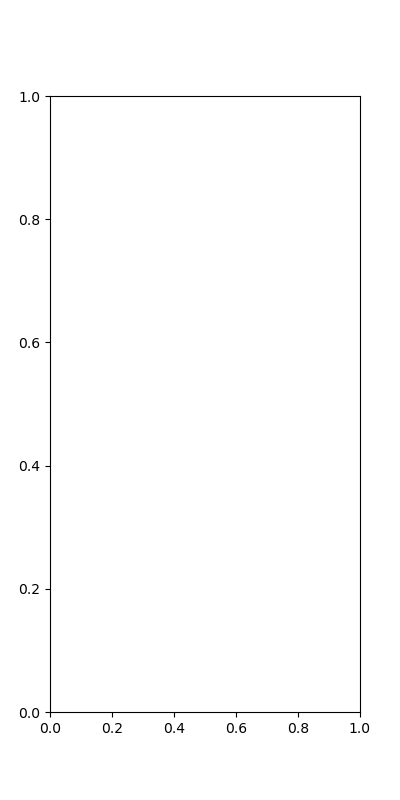

Ass(children=(VBox(children=(HTML(value='<u>Source heights</u>'), HBox(children=(FloatSlider(value=8.0, descri…

In [5]:
ass1 = Ass(dz=0.01, zhigh=12, plot_height=8, fMHz=400)
display(ass1);

## Scratch
*for testing out code ...*

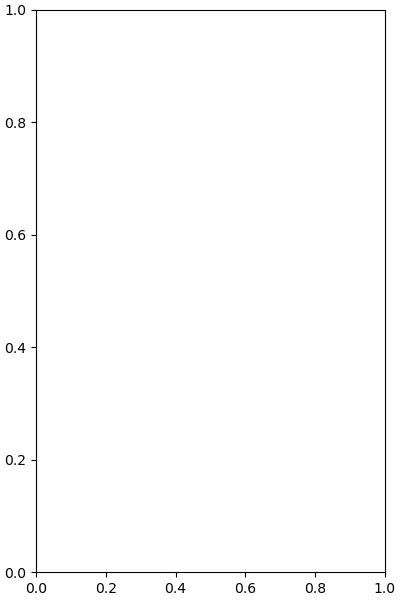

Butts(children=(Button(description='button 1', style=ButtonStyle()), Output(), Button(description='button 2', …

In [6]:
class Butts(widgets.HBox):
     
    def __init__(self):
        super().__init__()

        # Create plot
        output = widgets.Output()
        with plt.ioff():
            with output:
                self.fig, self.ax = plt.subplots(constrained_layout=True, figsize=(4, 6))
                display(self.fig.canvas)

        # Create buttons
        b1 = widgets.Button(description='button 1')
        b2 = widgets.Button(description='button 2')
        self.children = [b1,output,b2] 

Butts()